<a href="https://colab.research.google.com/github/adidev001/Loan-prediction-model-/blob/main/LOAN_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All libraries imported successfully!
LOADING DATASET...
Option 1: Upload your CSV file


Saving train_u6lujuX_CVtuZ9i.xls to train_u6lujuX_CVtuZ9i (1).xls
File 'train_u6lujuX_CVtuZ9i (1).xls' uploaded successfully!

Dataset Shape: (614, 13)
Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

First few rows:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             36

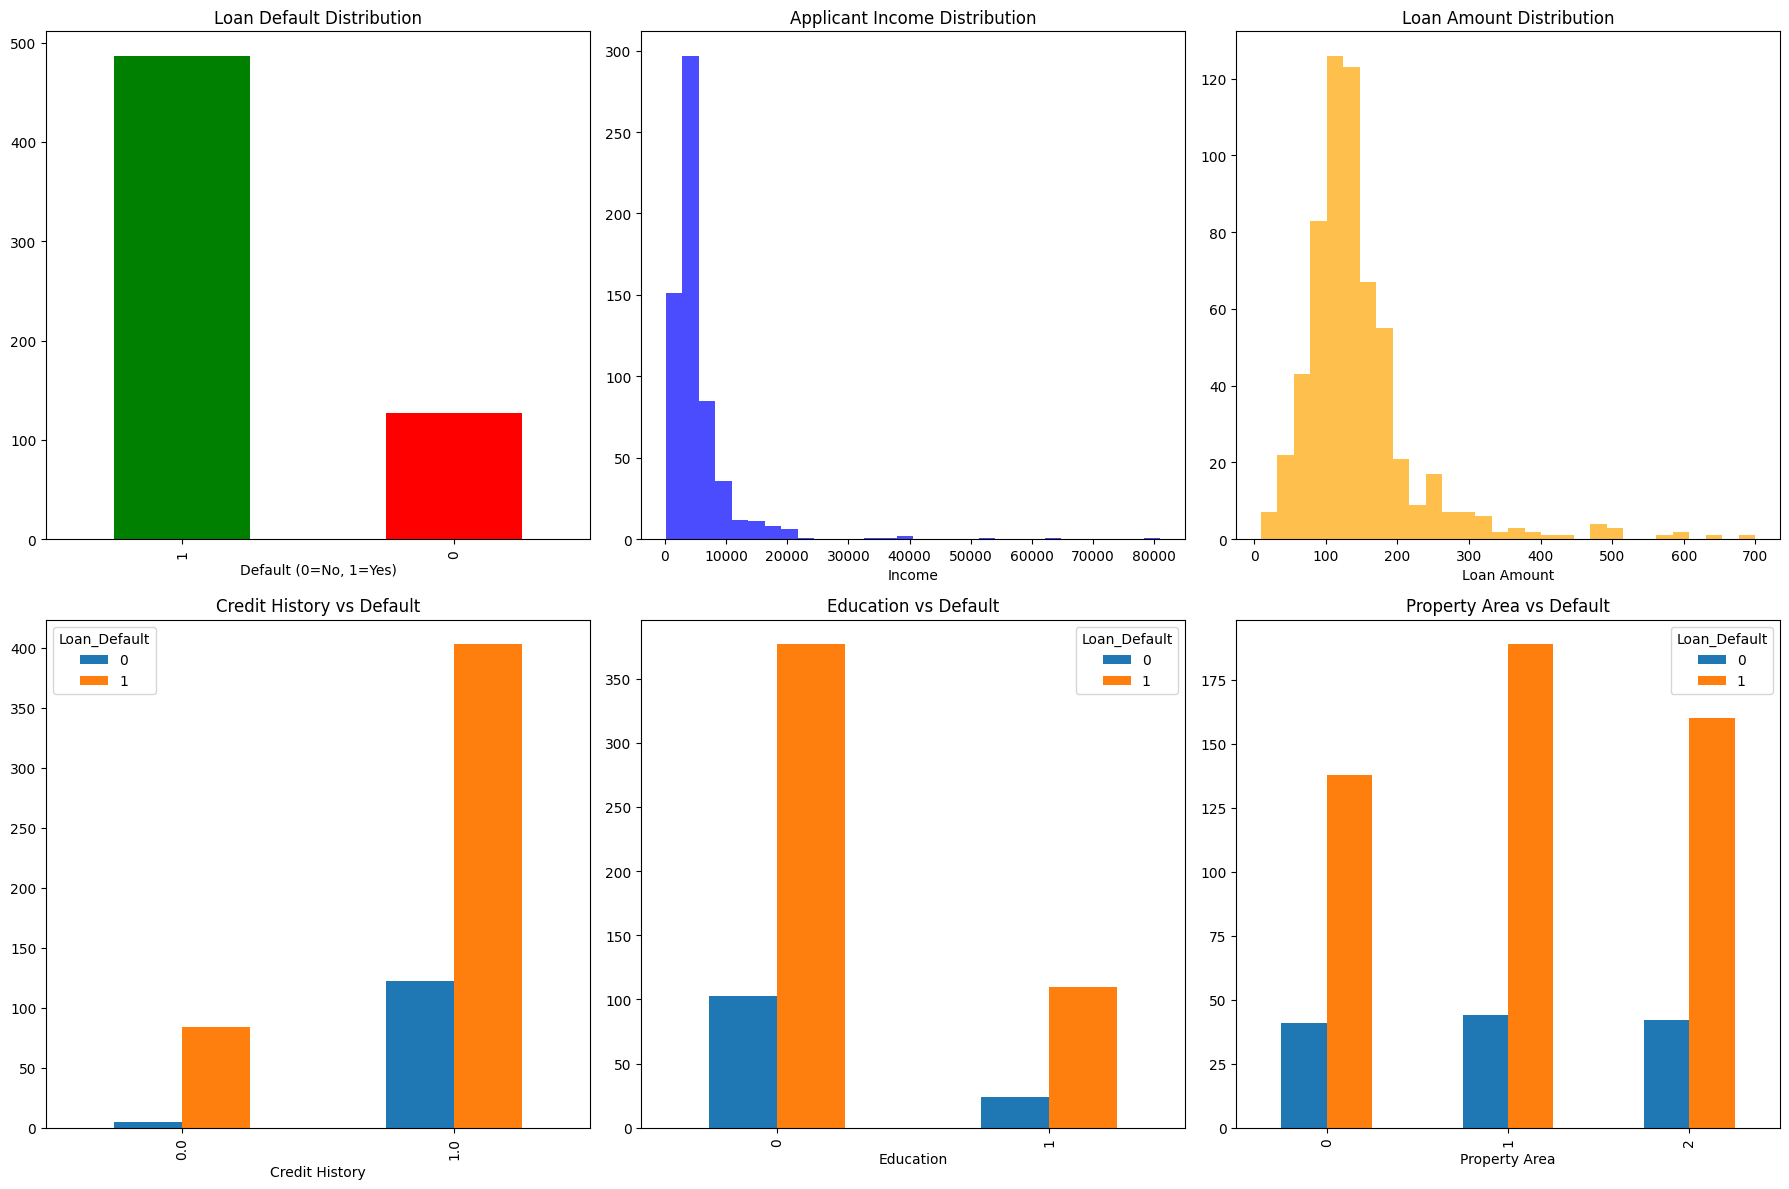

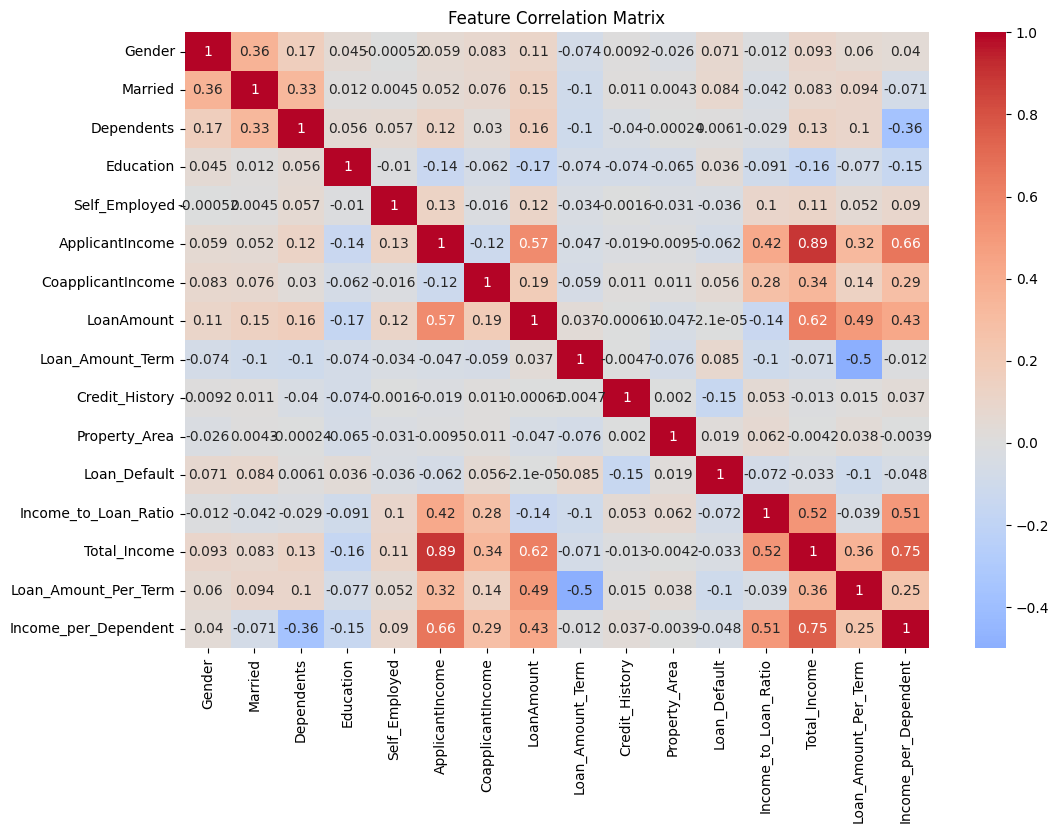


MODEL TRAINING

Training Random Forest...
Random Forest - Accuracy: 0.7561, AUC: 0.6949

Training Decision Tree...
Decision Tree - Accuracy: 0.6911, AUC: 0.5380

Training Logistic Regression...
Logistic Regression - Accuracy: 0.7967, AUC: 0.6620

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.7642, AUC: 0.6957

Training SVM...
SVM - Accuracy: 0.7886, AUC: 0.5816

MODEL EVALUATION

Model Comparison:
                     accuracy auc_score
Random Forest        0.756098  0.694898
Decision Tree        0.691057  0.537959
Logistic Regression  0.796748  0.662041
Gradient Boosting    0.764228  0.695714
SVM                  0.788618  0.581633


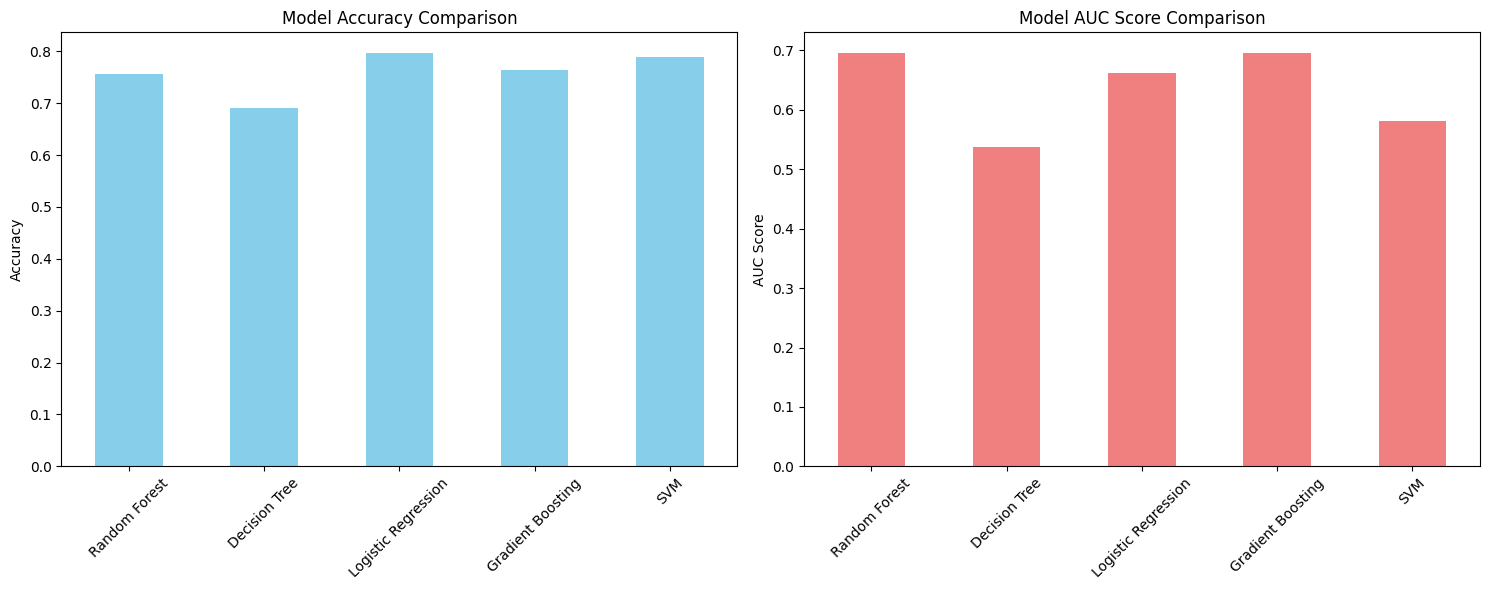

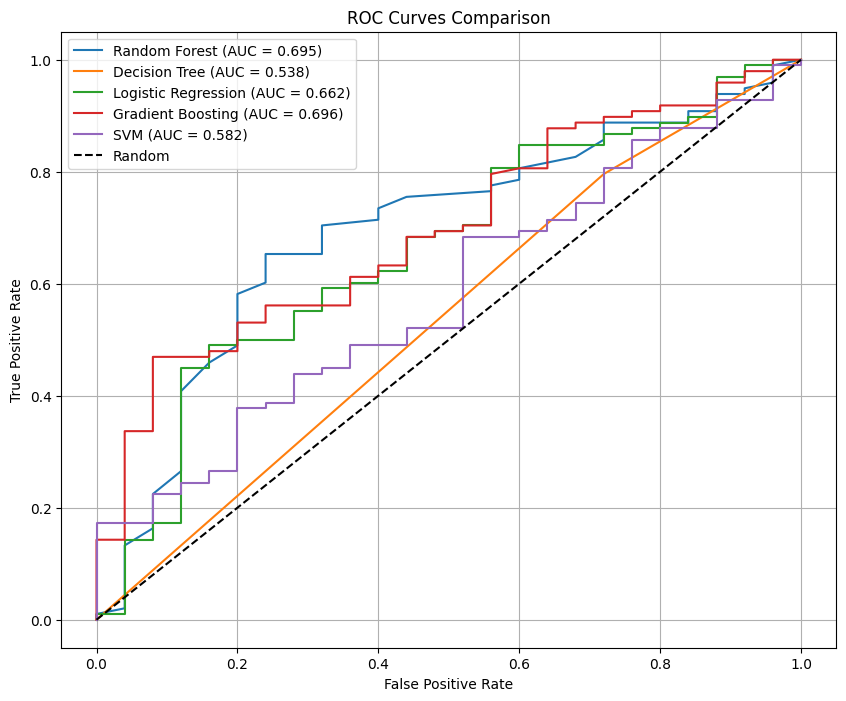

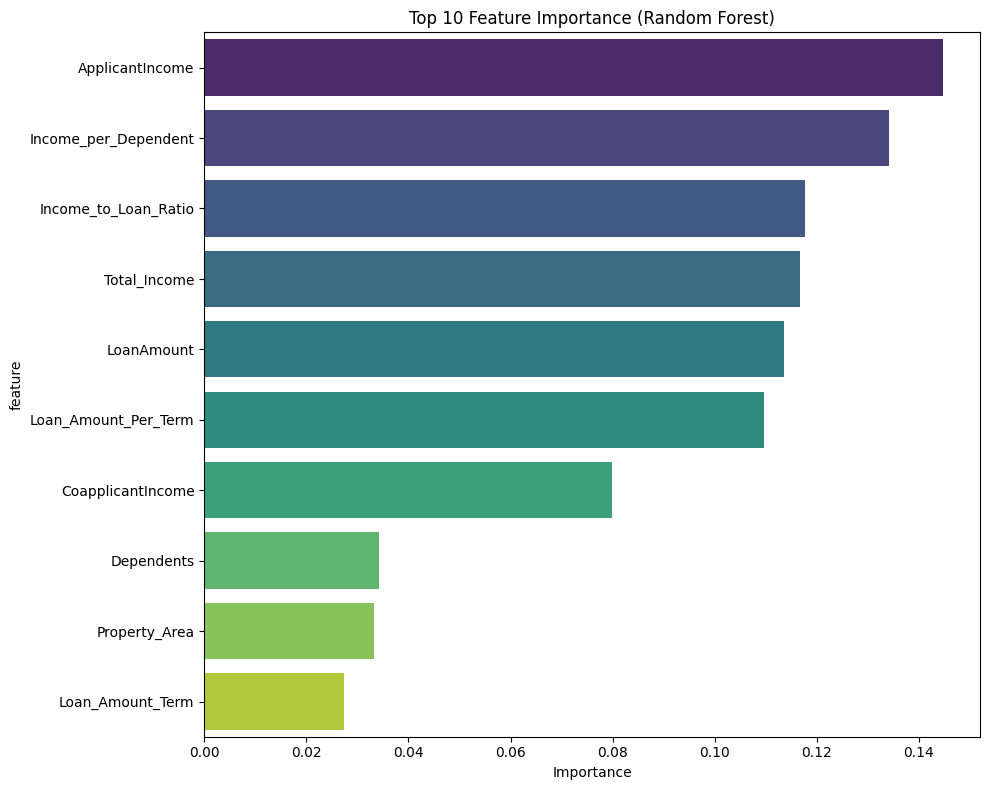


LOAN DEFAULT PREDICTION SYSTEM

Model training completed!
Best performing model: Logistic Regression (Accuracy: 0.7967)

Options:
1. Make a prediction for a new applicant
2. View model performance summary
3. View feature importance
4. Exit


In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly

# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer


from google.colab import files
import io

print("All libraries imported successfully!")
print("=" * 60)

# ================================
# STEP 1: DATA LOADING AND EXPLORATION
# ================================

def load_data():
    """Load the dataset - either upload or use provided data"""
    try:
        # Option 1: Upload file in Google Colab
        print("Option 1: Upload your CSV file")
        uploaded = files.upload()

        if uploaded:
            filename = list(uploaded.keys())[0]
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
            print(f"File '{filename}' uploaded successfully!")
        else:
            raise Exception("No file uploaded")

    except:
        # Option 2: Create sample data based on the provided dataset structure
        print("Using sample data structure...")
        # This would be replaced with your actual data loading
        df = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')  # Replace with your file path

    return df

# Load the data
print("LOADING DATASET...")
df = load_data()

print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

# ================================
# STEP 2: DATA PREPROCESSING
# ================================

def preprocess_data(df):
    """Comprehensive data preprocessing"""
    print("\n" + "="*50)
    print("DATA PREPROCESSING")
    print("="*50)

    # Create a copy
    data = df.copy()

    # Display basic info
    print(f"Original shape: {data.shape}")
    print(f"\nMissing values:")
    print(data.isnull().sum())

    # Since we don't have a 'Loan_Status' column, we'll create a synthetic target
    # based on some business logic (this is for demonstration)
    print("\nCreating target variable 'Loan_Default' based on Credit_History and other factors...")

    # Create synthetic target variable
    np.random.seed(42)
    data['Loan_Default'] = 0

    # Higher chance of default if:
    # - No credit history (Credit_History = 0)
    # - Very low income
    # - High loan amount relative to income

    # Calculate income to loan ratio
    data['Income_to_Loan_Ratio'] = (data['ApplicantIncome'] + data['CoapplicantIncome']) / (data['LoanAmount'].fillna(data['LoanAmount'].median()) * 1000)

    # Set default conditions
    conditions = [
        (data['Credit_History'] == 0),
        (data['ApplicantIncome'] < 3000),
        (data['Income_to_Loan_Ratio'] < 0.3),
        (data['LoanAmount'] > 200) & (data['ApplicantIncome'] < 5000)
    ]

    # Add some randomness but bias towards these conditions
    for condition in conditions:
        mask = condition.fillna(False)
        data.loc[mask, 'Loan_Default'] = np.where(
            np.random.random(mask.sum()) < 0.7, 1, data.loc[mask, 'Loan_Default']
        )

    # Add some random defaults to make it more realistic
    random_mask = np.random.random(len(data)) < 0.1
    data.loc[random_mask, 'Loan_Default'] = 1

    print(f"Target distribution:\n{data['Loan_Default'].value_counts()}")

    # Handle missing values
    print("\nHandling missing values...")

    # Categorical columns
    categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
    for col in categorical_columns:
        if col in data.columns:
            data[col] = data[col].fillna(data[col].mode()[0])

    # Numerical columns
    numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
    for col in numerical_columns:
        if col in data.columns:
            data[col] = data[col].fillna(data[col].median())

    # Feature Engineering
    print("Creating new features...")
    data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    data['Loan_Amount_Per_Term'] = data['LoanAmount'] / data['Loan_Amount_Term']
    data['Income_per_Dependent'] = data['Total_Income'] / (data['Dependents'].replace({'3+': '3'}).astype(float) + 1)

    # Convert 3+ to 3 in Dependents
    data['Dependents'] = data['Dependents'].replace({'3+': '3'})

    # Label Encoding for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

    # Convert Dependents to numeric
    data['Dependents'] = pd.to_numeric(data['Dependents'], errors='coerce').fillna(0)

    print(f"Processed shape: {data.shape}")
    print(f"Missing values after preprocessing:\n{data.isnull().sum().sum()}")

    return data, label_encoders

# Preprocess the data
processed_data, encoders = preprocess_data(df)

# ================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ================================

def perform_eda(data):
    """Perform exploratory data analysis with visualizations"""
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic statistics
    print("Dataset Info:")
    print(data.describe())

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Target distribution
    data['Loan_Default'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'red'])
    axes[0,0].set_title('Loan Default Distribution')
    axes[0,0].set_xlabel('Default (0=No, 1=Yes)')

    # Income distribution
    axes[0,1].hist(data['ApplicantIncome'], bins=30, alpha=0.7, color='blue')
    axes[0,1].set_title('Applicant Income Distribution')
    axes[0,1].set_xlabel('Income')

    # Loan amount distribution
    axes[0,2].hist(data['LoanAmount'].dropna(), bins=30, alpha=0.7, color='orange')
    axes[0,2].set_title('Loan Amount Distribution')
    axes[0,2].set_xlabel('Loan Amount')

    # Credit history vs Default
    pd.crosstab(data['Credit_History'], data['Loan_Default']).plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Credit History vs Default')
    axes[1,0].set_xlabel('Credit History')

    # Education vs Default
    pd.crosstab(data['Education'], data['Loan_Default']).plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Education vs Default')
    axes[1,1].set_xlabel('Education')

    # Property Area vs Default
    pd.crosstab(data['Property_Area'], data['Loan_Default']).plot(kind='bar', ax=axes[1,2])
    axes[1,2].set_title('Property Area vs Default')
    axes[1,2].set_xlabel('Property Area')

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

perform_eda(processed_data)

# ================================
# STEP 4: MODEL TRAINING
# ================================

def prepare_features(data):
    """Prepare features for model training"""
    # Select features (exclude target and ID)
    feature_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                      'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                      'Credit_History', 'Property_Area', 'Total_Income', 'Loan_Amount_Per_Term',
                      'Income_per_Dependent', 'Income_to_Loan_Ratio']

    # Filter columns that exist in the dataset
    available_features = [col for col in feature_columns if col in data.columns]

    X = data[available_features]
    y = data['Loan_Default']

    return X, y, available_features

def train_models(X, y):
    """Train multiple classification models"""
    print("\n" + "="*50)
    print("MODEL TRAINING")
    print("="*50)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }

    # Train and evaluate models
    model_results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Use scaled data for models that benefit from it
        if name in ['Logistic Regression', 'SVM']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        model_results[name] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        trained_models[name] = model

        print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")

    return trained_models, model_results, X_train, X_test, y_train, y_test, scaler

# Prepare data and train models
X, y, feature_names = prepare_features(processed_data)
models, results, X_train, X_test, y_train, y_test, scaler = train_models(X, y)

# ================================
# STEP 5: MODEL EVALUATION AND VISUALIZATION
# ================================

def evaluate_models(models, results, X_test, y_test, feature_names):
    """Evaluate models and create visualizations"""
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    # Model comparison
    comparison_df = pd.DataFrame(results).T[['accuracy', 'auc_score']]
    print("\nModel Comparison:")
    print(comparison_df.round(4))

    # Plot model comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    comparison_df['accuracy'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)

    # AUC comparison
    comparison_df['auc_score'].plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Model AUC Score Comparison')
    ax2.set_ylabel('AUC Score')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc_score']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Feature importance (using Random Forest)
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return comparison_df, feature_importance

# Evaluate models
comparison_results, feature_importance = evaluate_models(models, results, X_test, y_test, feature_names)

# ================================
# STEP 6: USER INPUT INTERFACE
# ================================

def get_user_input():
    """Get user input for loan prediction"""
    print("\n" + "="*60)
    print("LOAN DEFAULT PREDICTION - USER INPUT")
    print("="*60)

    user_data = {}

    # Gender
    print("\n1. Gender:")
    print("   0 - Female, 1 - Male")
    user_data['Gender'] = int(input("Enter Gender (0/1): "))

    # Married
    print("\n2. Marital Status:")
    print("   0 - No, 1 - Yes")
    user_data['Married'] = int(input("Are you married? (0/1): "))

    # Dependents
    print("\n3. Number of Dependents:")
    user_data['Dependents'] = int(input("Enter number of dependents (0-3): "))

    # Education
    print("\n4. Education:")
    print("   0 - Not Graduate, 1 - Graduate")
    user_data['Education'] = int(input("Education level (0/1): "))

    # Self Employed
    print("\n5. Employment:")
    print("   0 - Not Self Employed, 1 - Self Employed")
    user_data['Self_Employed'] = int(input("Self employed? (0/1): "))

    # Income
    user_data['ApplicantIncome'] = float(input("\n6. Enter your monthly income: "))
    user_data['CoapplicantIncome'] = float(input("7. Enter co-applicant monthly income (0 if none): "))

    # Loan details
    user_data['LoanAmount'] = float(input("8. Enter desired loan amount (in thousands): "))
    user_data['Loan_Amount_Term'] = float(input("9. Enter loan term in months (e.g., 360): "))

    # Credit History
    print("\n10. Credit History:")
    print("    0 - No prior credit history, 1 - Has credit history")
    user_data['Credit_History'] = int(input("Credit history (0/1): "))

    # Property Area
    print("\n11. Property Area:")
    print("    0 - Rural, 1 - Semiurban, 2 - Urban")
    user_data['Property_Area'] = int(input("Property area (0/1/2): "))

    return user_data

def predict_for_user(user_data, models, scaler, feature_names):
    """Make prediction for user input"""

    # Create engineered features
    user_data['Total_Income'] = user_data['ApplicantIncome'] + user_data['CoapplicantIncome']
    user_data['Loan_Amount_Per_Term'] = user_data['LoanAmount'] / user_data['Loan_Amount_Term']
    user_data['Income_per_Dependent'] = user_data['Total_Income'] / (user_data['Dependents'] + 1)
    user_data['Income_to_Loan_Ratio'] = user_data['Total_Income'] / (user_data['LoanAmount'] * 1000)

    # Create DataFrame
    user_df = pd.DataFrame([user_data])

    # Ensure all required features are present
    for feature in feature_names:
        if feature not in user_df.columns:
            user_df[feature] = 0  # Default value for missing features

    # Select features in the same order as training
    user_df = user_df[feature_names]

    print("\n" + "="*60)
    print("PREDICTION RESULTS")
    print("="*60)

    print(f"\nUser Input Summary:")
    print(f"Total Income: ${user_data['Total_Income']:,.2f}")
    print(f"Loan Amount: ${user_data['LoanAmount']*1000:,.2f}")
    print(f"Income to Loan Ratio: {user_data['Income_to_Loan_Ratio']:.2f}")

    # Make predictions with all models
    predictions = {}

    for name, model in models.items():
        if name in ['Logistic Regression', 'SVM']:
            user_scaled = scaler.transform(user_df)
            pred_proba = model.predict_proba(user_scaled)[0, 1]
            pred = model.predict(user_scaled)[0]
        else:
            pred_proba = model.predict_proba(user_df)[0, 1]
            pred = model.predict(user_df)[0]

        predictions[name] = {
            'default_probability': pred_proba,
            'prediction': pred
        }

    print(f"\n{'Model':<20} {'Default Risk':<15} {'Probability':<12} {'Decision'}")
    print("-" * 60)

    for name, pred in predictions.items():
        risk_level = "HIGH" if pred['default_probability'] > 0.5 else "LOW"
        decision = "REJECT" if pred['prediction'] == 1 else "APPROVE"
        print(f"{name:<20} {risk_level:<15} {pred['default_probability']:.3f}        {decision}")

    # Ensemble prediction (average of all models)
    avg_probability = np.mean([pred['default_probability'] for pred in predictions.values()])
    ensemble_decision = "REJECT" if avg_probability > 0.5 else "APPROVE"

    print("\n" + "="*60)
    print(f"ENSEMBLE PREDICTION:")
    print(f"Average Default Probability: {avg_probability:.3f}")
    print(f"Final Decision: {ensemble_decision}")

    if ensemble_decision == "APPROVE":
        print("✅ LOAN APPROVED - Low default risk")
    else:
        print("❌ LOAN REJECTED - High default risk")

    print("="*60)

    return predictions, avg_probability

# ================================
# STEP 7: MAIN EXECUTION
# ================================

def main():
    """Main execution function"""
    print("\n" + "="*60)
    print("LOAN DEFAULT PREDICTION SYSTEM")
    print("="*60)

    print(f"\nModel training completed!")
    print(f"Best performing model: {comparison_results['accuracy'].idxmax()} (Accuracy: {comparison_results['accuracy'].max():.4f})")

    while True:
        print(f"\nOptions:")
        print("1. Make a prediction for a new applicant")
        print("2. View model performance summary")
        print("3. View feature importance")
        print("4. Exit")

        choice = input("\nEnter your choice (1-4): ")

        if choice == '1':
            try:
                user_input = get_user_input()
                predictions, avg_prob = predict_for_user(user_input, models, scaler, feature_names)
            except Exception as e:
                print(f"Error in prediction: {e}")
                print("Please check your inputs and try again.")

        elif choice == '2':
            print("\nModel Performance Summary:")
            print(comparison_results.round(4))

        elif choice == '3':
            print("\nTop 10 Most Important Features:")
            print(feature_importance.head(10))

        elif choice == '4':
            print("Thank you for using the Loan Default Prediction System!")
            break

        else:
            print("Invalid choice. Please enter 1-4.")

# Run the main function
if __name__ == "__main__":
    main()